<a href="https://colab.research.google.com/github/nixx14/Ghost-BatchNormalisation-/blob/master/GhostBatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [39]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# note about pin_memory
# If you load your samples in the Dataset on CPU and would like to push it
# during training to the GPU, you can speed up the host to device transfer by
# enabling pin_memory. This lets your DataLoader allocate the samples in
# page-locked memory, which speeds-up the transfer.

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value=0.02
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            torch.nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26 rf=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout(dropout_value)
        ) # output_size = 24 rf=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 22 rf=5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 rf=6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9 rf=10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7 rf=14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout(dropout_value)
        ) # output_size = 5 rf=18

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )# output size = 1 rf=34

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.Dropout(dropout_value)
        ) # output_size = 1
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 25, 24, 24]           3,150
              ReLU-6           [-1, 25, 24, 24]               0
       BatchNorm2d-7           [-1, 25, 24, 24]              50
           Dropout-8           [-1, 25, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             250
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
          Dropout-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

In [30]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


In [40]:
import torch.nn.functional as F
dropout_value=0.02
class GhostNet(nn.Module):
    def __init__(self):
        super(GhostNet, self).__init__()
        
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(14,num_splits=4),
            nn.Dropout(dropout_value)
        ) # output_size = 26 rf=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(25,num_splits=4),
            nn.Dropout(dropout_value)
        ) # output_size = 24 rf=5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(10,num_splits=4),
            nn.Dropout(dropout_value)
        ) # output_size = 22 rf=5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 rf=6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            GhostBatchNorm(10,num_splits=4),
            nn.ReLU()
        ) # output_size = 9 rf=10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(16,num_splits=4),
            nn.Dropout(dropout_value)
        ) # output_size = 7 rf=14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=25, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(25,num_splits=4),
            nn.Dropout(dropout_value)
        ) # output_size = 5 rf=18

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )# output size = 1 rf=34

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(32),
            #nn.Dropout(dropout_value)
        ) # output_size = 1
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Trainer():
    """Trainer Class
    """

    def __init__(self, model, optimizer, train_loader, test_loader,
                 lr_scheduler=None, use_cuda=True):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        self.lr_scheduler = lr_scheduler

    def train(self, n_epoch=5, l1_lambda=0, l2_lambda=0, loss_func='nll'):
        """train
        Trains the model for n_epoch number of times
        """

        # set the loss function
        if loss_func == 'mse':
            self.loss_func = nn.MSELoss
        elif loss_func == 'nll':
            self.loss_func = F.nll_loss

        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # set the l2 lambda in the optimizer
        # for param_group in self.optimizer.param_groups:
        #     param_group['weight_decay'] = self.l2_lambda
        
        train_losses = []
        test_losses  = []
        train_acc    = []
        test_acc     = []
        lr_values    = []

        print('Training the model for {} epochs'.format(n_epoch))

        for epoch in range(1, n_epoch+1):
            # store the current LR value
            if self.lr_scheduler is not None:
                lr_values.append(self.lr_scheduler)
                print('EPOCH:', epoch, 'LR:', self.lr_scheduler.get_lr())
            else:
                print('EPOCH:', epoch)

            # train the model
            c_train_acc, c_train_loss = self._train_epoch(epoch)

            # validate the model
            c_test_acc, c_test_loss = self.test()

            train_acc.extend(c_train_acc)
            train_losses.extend(c_train_loss)
            test_acc.extend(c_test_acc)
            test_losses.extend(c_test_loss)
        
        return ((train_acc, train_losses), (test_acc, test_losses) , lr_values)

    def _train_epoch(self, epoch):
        # this automatically selects tqdm for colab_notebook
        from tqdm.auto import tqdm, trange

        """train_epoch
        Training logic for an epoch

        :param epoch: Integer, current epoch number
        :return: a log that contains the train_accuracy, train_loss, lr_values
        """

        train_acc  = []
        train_loss = []
        lr_values  = []

        correct = 0
        processed = 0

        self.model.train()

        pbar = tqdm(self.train_loader, ncols="80%")

        for batch_idx, (data, target) in enumerate(pbar):

            data, target = data.to(self.device), target.to(self.device) # get samples

            self.optimizer.zero_grad() # init

            # Predict
            y_pred = self.model(data)

            # Calculate loss
            criterion = self.loss_func(y_pred, target)

            if self.l1_lambda > 0:
                # l1 regularization
                l1_reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])

                loss = criterion + self.l2_lambda * l1_reg_loss
            else:
                loss = criterion

            train_loss.append(loss.data.cpu().numpy().item())

            # Backpropagation
            loss.backward()
            self.optimizer.step()

            # Update the Learning Rate
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            
            # get the index of the max log-probability
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

            # Update pbar-tqdm
            pbar.set_description(desc= f'epoch={epoch} loss={loss.item()} batch_id={batch_idx} accuracy={100*correct/processed:0.2f}')
            train_acc.append(100*correct/processed)

        return (train_acc, train_loss)

    def test(self):
        test_losses = []
        test_acc    = []

        # set the model in evaluation mode
        self.model.eval()

        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                # sum up batch loss
                test_loss += self.loss_func(output, target, reduction='sum').item()
                # get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        test_losses.append(test_loss)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100. * correct / len(self.test_loader.dataset)))
        
        test_acc.append(100. * correct / len(self.test_loader.dataset))

        return (test_acc, test_losses)

    def get_misclassified(self):
        misclassified = []
        misclassified_pred = []
        misclassified_target = []
        # put the model to evaluation mode
        self.model.eval()
        # turn off gradients
        with torch.no_grad():
            for data, target in self.test_loader:
                # move them to the respective device
                data, target = data.to(self.device), target.to(self.device)
                # do inferencing
                output = self.model(data)
                # get the predicted output
                pred = output.argmax(dim=1, keepdim=True)

                # get the current misclassified in this batch
                list_misclassified = (pred.eq(target.view_as(pred)) == False)
                batch_misclassified = data[list_misclassified]
                batch_mis_pred = pred[list_misclassified]
                batch_mis_target = target.view_as(pred)[list_misclassified]

                # batch_misclassified =

                misclassified.append(batch_misclassified)
                misclassified_pred.append(batch_mis_pred)
                misclassified_target.append(batch_mis_target)

        # group all the batched together
        misclassified = torch.cat(misclassified)
        misclassified_pred = torch.cat(misclassified_pred)
        misclassified_target = torch.cat(misclassified_target)

        return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

def plot_metrics(train_metric, test_metric):
    (train_acc, train_losses) = train_metric
    (test_acc, test_losses) = test_metric

    fig, axs = plt.subplots(2,2,figsize=(14,10))
    fig.suptitle('Metrics')
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
    plt.show()

def plot_misclassification(misclassified):
    print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
        ax.imshow(image.squeeze())
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
import copy # to perform a deep copy of the model
from torch.optim.lr_scheduler import OneCycleLR

# for saving the metrics and models into a dictionary
metric_values = {}
models = {}

EPOCHS = 25

In [18]:
model = Net().to(device)
metrics = []

for i in range(1,4):
  if i==1:
    print("With L1 + BN")
    model1 = Net().to(device)
    optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.95)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

    trainer1 = Trainer(model1, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)
    metrics.append(trainer1.train(n_epoch=EPOCHS, l1_lambda=5e-4, l2_lambda=0))
  if i==2:
    print("With L2 + BN")
    model2 = Net().to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.95, weight_decay=5e-3)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

    trainer2 = Trainer(model2, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)
    metrics.append(trainer2.train(n_epoch=EPOCHS, l1_lambda=0, l2_lambda=5e-3))
  if i==3:
    print("With L2 + L1 +BN")
    model3 = Net().to(device)
    optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.95, weight_decay=5e-3)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

    trainer3 = Trainer(model3, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)
    metrics.append(trainer3.train(n_epoch=EPOCHS, l1_lambda=5e-4, l2_lambda=5e-3))      
    


With L1 + BN
Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)




Test set: Average loss: 0.7242, Accuracy: 8463/10000 (84.63%)

EPOCH: 2 LR: [0.0008152143930893266]




Test set: Average loss: 0.1638, Accuracy: 9669/10000 (96.69%)

EPOCH: 3 LR: [0.0019890229922620867]




Test set: Average loss: 0.0893, Accuracy: 9777/10000 (97.77%)

EPOCH: 4 LR: [0.0037183498703897153]




Test set: Average loss: 0.0696, Accuracy: 9819/10000 (98.19%)

EPOCH: 5 LR: [0.005704011106574366]




Test set: Average loss: 0.0546, Accuracy: 9840/10000 (98.40%)

EPOCH: 6 LR: [0.007602475398706288]




Test set: Average loss: 0.0438, Accuracy: 9864/10000 (98.64%)

EPOCH: 7 LR: [0.009085297038927428]




Test set: Average loss: 0.0394, Accuracy: 9886/10000 (98.86%)

EPOCH: 8 LR: [0.009895938990819394]




Test set: Average loss: 0.0378, Accuracy: 9895/10000 (98.95%)

EPOCH: 9 LR: [0.009979699629751147]




Test set: Average loss: 0.0283, Accuracy: 9919/10000 (99.19%)

EPOCH: 10 LR: [0.009819305517294569]




Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 11 LR: [0.009504015602990813]




Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)

EPOCH: 12 LR: [0.009043963564107005]




Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 13 LR: [0.008453935851704949]




Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 14 LR: [0.007752896441937668]




Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

EPOCH: 15 LR: [0.00696337731825223]




Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 16 LR: [0.0061107542749023825]




Test set: Average loss: 0.0239, Accuracy: 9938/10000 (99.38%)

EPOCH: 17 LR: [0.005222431318041966]




Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 18 LR: [0.004326959878419038]




Test set: Average loss: 0.0242, Accuracy: 9918/10000 (99.18%)

EPOCH: 19 LR: [0.003453121144899437]




Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)

EPOCH: 20 LR: [0.002629001013375387]




Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 21 LR: [0.0018810873829623678]




Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 22 LR: [0.001233418813127246]




Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 23 LR: [0.0007068119046079938]




Test set: Average loss: 0.0188, Accuracy: 9943/10000 (99.43%)

EPOCH: 24 LR: [0.00031819223673802856]




Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 25 LR: [8.005036540001837e-05]




Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

With L2 + BN
Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.7789, Accuracy: 8830/10000 (88.30%)

EPOCH: 2 LR: [0.0008152143930893266]




Test set: Average loss: 0.1987, Accuracy: 9625/10000 (96.25%)

EPOCH: 3 LR: [0.0019890229922620867]




Test set: Average loss: 0.1162, Accuracy: 9718/10000 (97.18%)

EPOCH: 4 LR: [0.0037183498703897153]




Test set: Average loss: 0.0783, Accuracy: 9836/10000 (98.36%)

EPOCH: 5 LR: [0.005704011106574366]




Test set: Average loss: 0.0772, Accuracy: 9832/10000 (98.32%)

EPOCH: 6 LR: [0.007602475398706288]




Test set: Average loss: 0.0644, Accuracy: 9860/10000 (98.60%)

EPOCH: 7 LR: [0.009085297038927428]




Test set: Average loss: 0.0767, Accuracy: 9839/10000 (98.39%)

EPOCH: 8 LR: [0.009895938990819394]




Test set: Average loss: 0.0624, Accuracy: 9875/10000 (98.75%)

EPOCH: 9 LR: [0.009979699629751147]




Test set: Average loss: 0.0594, Accuracy: 9873/10000 (98.73%)

EPOCH: 10 LR: [0.009819305517294569]




Test set: Average loss: 0.0731, Accuracy: 9822/10000 (98.22%)

EPOCH: 11 LR: [0.009504015602990813]




Test set: Average loss: 0.0683, Accuracy: 9852/10000 (98.52%)

EPOCH: 12 LR: [0.009043963564107005]




Test set: Average loss: 0.0677, Accuracy: 9859/10000 (98.59%)

EPOCH: 13 LR: [0.008453935851704949]




Test set: Average loss: 0.0755, Accuracy: 9855/10000 (98.55%)

EPOCH: 14 LR: [0.007752896441937668]




Test set: Average loss: 0.0586, Accuracy: 9861/10000 (98.61%)

EPOCH: 15 LR: [0.00696337731825223]




Test set: Average loss: 0.0599, Accuracy: 9876/10000 (98.76%)

EPOCH: 16 LR: [0.0061107542749023825]




Test set: Average loss: 0.0551, Accuracy: 9886/10000 (98.86%)

EPOCH: 17 LR: [0.005222431318041966]




Test set: Average loss: 0.0571, Accuracy: 9884/10000 (98.84%)

EPOCH: 18 LR: [0.004326959878419038]




Test set: Average loss: 0.0678, Accuracy: 9869/10000 (98.69%)

EPOCH: 19 LR: [0.003453121144899437]




Test set: Average loss: 0.0588, Accuracy: 9877/10000 (98.77%)

EPOCH: 20 LR: [0.002629001013375387]




Test set: Average loss: 0.0471, Accuracy: 9883/10000 (98.83%)

EPOCH: 21 LR: [0.0018810873829623678]




Test set: Average loss: 0.0485, Accuracy: 9902/10000 (99.02%)

EPOCH: 22 LR: [0.001233418813127246]




Test set: Average loss: 0.0402, Accuracy: 9917/10000 (99.17%)

EPOCH: 23 LR: [0.0007068119046079938]




Test set: Average loss: 0.0388, Accuracy: 9911/10000 (99.11%)

EPOCH: 24 LR: [0.00031819223673802856]




Test set: Average loss: 0.0385, Accuracy: 9922/10000 (99.22%)

EPOCH: 25 LR: [8.005036540001837e-05]




Test set: Average loss: 0.0372, Accuracy: 9928/10000 (99.28%)

With L2 + L1 +BN
Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]




Test set: Average loss: 0.6233, Accuracy: 9227/10000 (92.27%)

EPOCH: 2 LR: [0.0008152143930893266]




Test set: Average loss: 0.1727, Accuracy: 9667/10000 (96.67%)

EPOCH: 3 LR: [0.0019890229922620867]




Test set: Average loss: 0.1277, Accuracy: 9688/10000 (96.88%)

EPOCH: 4 LR: [0.0037183498703897153]




Test set: Average loss: 0.0840, Accuracy: 9811/10000 (98.11%)

EPOCH: 5 LR: [0.005704011106574366]




Test set: Average loss: 0.0784, Accuracy: 9836/10000 (98.36%)

EPOCH: 6 LR: [0.007602475398706288]




Test set: Average loss: 0.0718, Accuracy: 9834/10000 (98.34%)

EPOCH: 7 LR: [0.009085297038927428]




Test set: Average loss: 0.0907, Accuracy: 9762/10000 (97.62%)

EPOCH: 8 LR: [0.009895938990819394]




Test set: Average loss: 0.0746, Accuracy: 9847/10000 (98.47%)

EPOCH: 9 LR: [0.009979699629751147]




Test set: Average loss: 0.0613, Accuracy: 9886/10000 (98.86%)

EPOCH: 10 LR: [0.009819305517294569]




Test set: Average loss: 0.0626, Accuracy: 9861/10000 (98.61%)

EPOCH: 11 LR: [0.009504015602990813]




Test set: Average loss: 0.0599, Accuracy: 9868/10000 (98.68%)

EPOCH: 12 LR: [0.009043963564107005]




Test set: Average loss: 0.0832, Accuracy: 9794/10000 (97.94%)

EPOCH: 13 LR: [0.008453935851704949]




Test set: Average loss: 0.0747, Accuracy: 9851/10000 (98.51%)

EPOCH: 14 LR: [0.007752896441937668]




Test set: Average loss: 0.0682, Accuracy: 9852/10000 (98.52%)

EPOCH: 15 LR: [0.00696337731825223]




Test set: Average loss: 0.0708, Accuracy: 9853/10000 (98.53%)

EPOCH: 16 LR: [0.0061107542749023825]




Test set: Average loss: 0.0635, Accuracy: 9872/10000 (98.72%)

EPOCH: 17 LR: [0.005222431318041966]




Test set: Average loss: 0.0593, Accuracy: 9870/10000 (98.70%)

EPOCH: 18 LR: [0.004326959878419038]




Test set: Average loss: 0.0545, Accuracy: 9894/10000 (98.94%)

EPOCH: 19 LR: [0.003453121144899437]




Test set: Average loss: 0.0504, Accuracy: 9898/10000 (98.98%)

EPOCH: 20 LR: [0.002629001013375387]




Test set: Average loss: 0.0436, Accuracy: 9908/10000 (99.08%)

EPOCH: 21 LR: [0.0018810873829623678]




Test set: Average loss: 0.0485, Accuracy: 9904/10000 (99.04%)

EPOCH: 22 LR: [0.001233418813127246]




Test set: Average loss: 0.0410, Accuracy: 9922/10000 (99.22%)

EPOCH: 23 LR: [0.0007068119046079938]




Test set: Average loss: 0.0364, Accuracy: 9930/10000 (99.30%)

EPOCH: 24 LR: [0.00031819223673802856]




Test set: Average loss: 0.0356, Accuracy: 9935/10000 (99.35%)

EPOCH: 25 LR: [8.005036540001837e-05]




Test set: Average loss: 0.0352, Accuracy: 9938/10000 (99.38%)



In [43]:
len(metrics)

5

In [10]:
experiment_name = 'nol1_nol2'

# move the model to device
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# create our Trainer object
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
train_metric, test_metric, lr_values = trainer.train(n_epoch=EPOCHS, l1_lambda=0, l2_lambda=0)

# save the metrics
metric_values[experiment_name] = copy.deepcopy((train_metric, test_metric))

# save the model
#models[experiment_name] = copy.deepcopy(model)
#torch.save(model, './{}'.format(experiment_name))

Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)




Test set: Average loss: 0.5844, Accuracy: 9127/10000 (91.27%)

EPOCH: 2 LR: [0.0008152143930893266]




Test set: Average loss: 0.1601, Accuracy: 9650/10000 (96.50%)

EPOCH: 3 LR: [0.0019890229922620867]




Test set: Average loss: 0.0894, Accuracy: 9783/10000 (97.83%)

EPOCH: 4 LR: [0.0037183498703897153]




Test set: Average loss: 0.0709, Accuracy: 9832/10000 (98.32%)

EPOCH: 5 LR: [0.005704011106574366]




Test set: Average loss: 0.0516, Accuracy: 9872/10000 (98.72%)

EPOCH: 6 LR: [0.007602475398706288]




Test set: Average loss: 0.0411, Accuracy: 9877/10000 (98.77%)

EPOCH: 7 LR: [0.009085297038927428]




Test set: Average loss: 0.0386, Accuracy: 9890/10000 (98.90%)

EPOCH: 8 LR: [0.009895938990819394]




Test set: Average loss: 0.0325, Accuracy: 9909/10000 (99.09%)

EPOCH: 9 LR: [0.009979699629751147]




Test set: Average loss: 0.0352, Accuracy: 9904/10000 (99.04%)

EPOCH: 10 LR: [0.009819305517294569]




Test set: Average loss: 0.0333, Accuracy: 9903/10000 (99.03%)

EPOCH: 11 LR: [0.009504015602990813]




Test set: Average loss: 0.0255, Accuracy: 9937/10000 (99.37%)

EPOCH: 12 LR: [0.009043963564107005]




Test set: Average loss: 0.0289, Accuracy: 9924/10000 (99.24%)

EPOCH: 13 LR: [0.008453935851704949]




Test set: Average loss: 0.0237, Accuracy: 9934/10000 (99.34%)

EPOCH: 14 LR: [0.007752896441937668]




Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 15 LR: [0.00696337731825223]




Test set: Average loss: 0.0242, Accuracy: 9933/10000 (99.33%)

EPOCH: 16 LR: [0.0061107542749023825]




Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 17 LR: [0.005222431318041966]




Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 18 LR: [0.004326959878419038]




Test set: Average loss: 0.0205, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 LR: [0.003453121144899437]




Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 20 LR: [0.002629001013375387]




Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 21 LR: [0.0018810873829623678]




Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

EPOCH: 22 LR: [0.001233418813127246]




Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 23 LR: [0.0007068119046079938]




Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 24 LR: [0.00031819223673802856]




Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 25 LR: [8.005036540001837e-05]




Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)



In [38]:
model = GhostNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)
trainer = Trainer(model, optimizer, train_loader, test_loader,
                  lr_scheduler=scheduler, use_cuda=True)

# train and test the model
metrics.append(trainer.train(n_epoch=EPOCHS, l1_lambda=0, l2_lambda=0))

Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)




Test set: Average loss: 0.6673, Accuracy: 8830/10000 (88.30%)

EPOCH: 2 LR: [0.0008152143930893266]




Test set: Average loss: 0.1573, Accuracy: 9675/10000 (96.75%)

EPOCH: 3 LR: [0.0019890229922620867]




Test set: Average loss: 0.0772, Accuracy: 9800/10000 (98.00%)

EPOCH: 4 LR: [0.0037183498703897153]




Test set: Average loss: 0.0656, Accuracy: 9822/10000 (98.22%)

EPOCH: 5 LR: [0.005704011106574366]




Test set: Average loss: 0.0494, Accuracy: 9850/10000 (98.50%)

EPOCH: 6 LR: [0.007602475398706288]




Test set: Average loss: 0.0519, Accuracy: 9860/10000 (98.60%)

EPOCH: 7 LR: [0.009085297038927428]




Test set: Average loss: 0.0391, Accuracy: 9885/10000 (98.85%)

EPOCH: 8 LR: [0.009895938990819394]




Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99.03%)

EPOCH: 9 LR: [0.009979699629751147]




Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 10 LR: [0.009819305517294569]




Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)

EPOCH: 11 LR: [0.009504015602990813]




Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 12 LR: [0.009043963564107005]




Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH: 13 LR: [0.008453935851704949]




Test set: Average loss: 0.0296, Accuracy: 9905/10000 (99.05%)

EPOCH: 14 LR: [0.007752896441937668]




Test set: Average loss: 0.0246, Accuracy: 9931/10000 (99.31%)

EPOCH: 15 LR: [0.00696337731825223]




Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 16 LR: [0.0061107542749023825]




Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.44%)

EPOCH: 17 LR: [0.005222431318041966]




Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 18 LR: [0.004326959878419038]




Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 19 LR: [0.003453121144899437]




Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 20 LR: [0.002629001013375387]




Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH: 21 LR: [0.0018810873829623678]




Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 22 LR: [0.001233418813127246]




Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH: 23 LR: [0.0007068119046079938]




Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

EPOCH: 24 LR: [0.00031819223673802856]




Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)

EPOCH: 25 LR: [8.005036540001837e-05]




Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.44%)



In [41]:
print('L1 + L2 + GBN')
model5 = GhostNet().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.95, weight_decay=5e-3)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=EPOCHS)

trainer5 = Trainer(model5, optimizer, train_loader, test_loader,
              lr_scheduler=scheduler, use_cuda=True)
metrics.append(trainer5.train(n_epoch=EPOCHS, l1_lambda=5e-4, l2_lambda=5e-3))

L1 + L2 + GBN
Training the model for 25 epochs
EPOCH: 1 LR: [0.0003999999999999993]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)




Test set: Average loss: 1.7546, Accuracy: 5450/10000 (54.50%)

EPOCH: 2 LR: [0.0008159074002507035]




Test set: Average loss: 0.9666, Accuracy: 8517/10000 (85.17%)

EPOCH: 3 LR: [0.001991555032009774]




Test set: Average loss: 0.3825, Accuracy: 9403/10000 (94.03%)

EPOCH: 4 LR: [0.0037232093327206235]




Test set: Average loss: 0.1991, Accuracy: 9650/10000 (96.50%)

EPOCH: 5 LR: [0.005710783703074251]




Test set: Average loss: 0.1351, Accuracy: 9732/10000 (97.32%)

EPOCH: 6 LR: [0.007609841939246196]




Test set: Average loss: 0.1872, Accuracy: 9496/10000 (94.96%)

EPOCH: 7 LR: [0.009091287218765223]




Test set: Average loss: 0.0881, Accuracy: 9815/10000 (98.15%)

EPOCH: 8 LR: [0.009898392852123652]




Test set: Average loss: 0.0815, Accuracy: 9823/10000 (98.23%)

EPOCH: 9 LR: [0.009979183925638924]




Test set: Average loss: 0.0729, Accuracy: 9833/10000 (98.33%)

EPOCH: 10 LR: [0.009817785776425548]




Test set: Average loss: 0.0760, Accuracy: 9816/10000 (98.16%)

EPOCH: 11 LR: [0.00950154067108697]




Test set: Average loss: 0.0668, Accuracy: 9846/10000 (98.46%)

EPOCH: 12 LR: [0.009040612987516112]




Test set: Average loss: 0.0685, Accuracy: 9849/10000 (98.49%)

EPOCH: 13 LR: [0.008449817320715501]




Test set: Average loss: 0.0584, Accuracy: 9870/10000 (98.70%)

EPOCH: 14 LR: [0.007748142329524404]




Test set: Average loss: 0.0633, Accuracy: 9861/10000 (98.61%)

EPOCH: 15 LR: [0.006958140425499809]




Test set: Average loss: 0.0565, Accuracy: 9877/10000 (98.77%)

EPOCH: 16 LR: [0.006105202919852796]




Test set: Average loss: 0.0610, Accuracy: 9874/10000 (98.74%)

EPOCH: 17 LR: [0.005216743925814179]




Test set: Average loss: 0.0549, Accuracy: 9884/10000 (98.84%)

EPOCH: 18 LR: [0.004321319246478855]




Test set: Average loss: 0.0555, Accuracy: 9881/10000 (98.81%)

EPOCH: 19 LR: [0.0034477085677985407]




Test set: Average loss: 0.0517, Accuracy: 9889/10000 (98.89%)

EPOCH: 20 LR: [0.002623990455795282]




Test set: Average loss: 0.0498, Accuracy: 9899/10000 (98.99%)

EPOCH: 21 LR: [0.0018766398883463835]




Test set: Average loss: 0.0514, Accuracy: 9892/10000 (98.92%)

EPOCH: 22 LR: [0.0012296773276117485]




Test set: Average loss: 0.0493, Accuracy: 9897/10000 (98.97%)

EPOCH: 23 LR: [0.0007038966826159559]




Test set: Average loss: 0.0473, Accuracy: 9899/10000 (98.99%)

EPOCH: 24 LR: [0.00031619697590292545]




Test set: Average loss: 0.0476, Accuracy: 9906/10000 (99.06%)

EPOCH: 25 LR: [7.903919504679743e-05]




Test set: Average loss: 0.0474, Accuracy: 9904/10000 (99.04%)



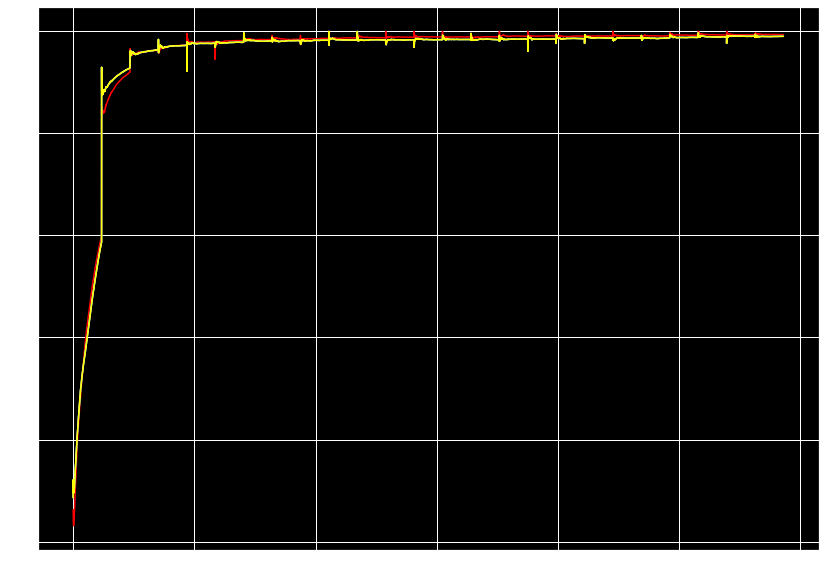

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=14,10

plt.plot(metrics[0][0][0],color = 'red')
plt.plot(metrics[1][0][0],color  = 'blue')
plt.plot(metrics[1][0][0],color  = 'green')
plt.plot(metrics[1][0][0],color  = 'white')
plt.plot(metrics[1][0][0],color  = 'yellow')
plt.show()